# Settings

In [1]:
# Main switch
main_mode = 'vanilla' # one of 'vanilla', 'random', aware'

# Error bands
error_band_mode = 'none' # one of 'none', 'toy', ...

# Other main settings
interpolate_gp = False

In [2]:
# Which results to show
do_carl = True
do_carl2 = True
do_score = True
do_score2 = True
do_combined = True
do_combined2 = True
do_regression = True
do_combinedregression = True

if main_mode == 'vanilla':
    common = '_shallow'
    
elif main_mode == 'random':
    common = '_random_shallow'
    
elif main_mode == 'aware':
    common = '_aware'
    
else:
    raise ValueError
    
suffix_score = common
suffix_score2 = '_calibrated' + common
suffix_carl = common
suffix_carl2 = '_calibrated' + common
suffix_combined = common
suffix_combined2 = '_calibrated' + common
suffix_regression = common
suffix_combinedregression = common

# Preparations

In [3]:
import math
import copy
import itertools
import numpy as np
import pandas as pd
import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

In [4]:
thetas = np.load('data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_test = 213
theta_observed = 0
theta_score = 0 # for local model
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

print thetas[theta1]
print thetas[theta_test]

[ 0.39293227  0.43229216]
[-0.59279349 -0.2797367 ]


In [5]:
def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Load results from cluster runs

In [6]:
def _load(name):
    return np.load('data/results/' + name + '.npy')

X_observed = np.load('data/unweighted_events/X_test.npy')

llr_truth = _load('llr_truth')
r_nottrained_truth = _load('r_nottrained_truth')
r_trained_truth = _load('r_trained_truth')
r_roam_truth = _load('r_roam_truth')
scores_nottrained_truth = _load('scores_nottrained_truth')
scores_trained_truth = _load('scores_trained_truth')
if error_band_mode == 'toy':
    pseudoexperiments_variance_truth = _load('pseudoexperiments_variance_truth')

if do_regression:
    llr_regression = _load('llr_regression' + suffix_regression)
    r_nottrained_regression = _load('r_nottrained_regression' + suffix_regression)
    r_trained_regression = _load('r_trained_regression' + suffix_regression)
    r_roam_regression = _load('r_roam_regression' + suffix_regression)
    scores_nottrained_regression = _load('scores_nottrained_regression' + suffix_regression)
    scores_trained_regression = _load('scores_trained_regression' + suffix_regression)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_regression = _load('pseudoexperiments_variance_regression' + suffix_regression)

if do_carl:
    llr_carl = _load('llr_carl' + suffix_carl)
    r_nottrained_carl = _load('r_nottrained_carl' + suffix_carl)
    r_trained_carl = _load('r_trained_carl' + suffix_carl)
    r_roam_carl = _load('r_roam_carl' + suffix_carl)
    scores_nottrained_carl = _load('scores_nottrained_carl' + suffix_carl)
    scores_trained_carl = _load('scores_trained_carl' + suffix_carl)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_carl = _load('pseudoexperiments_variance_carl' + suffix_carl)
    
if do_carl2:
    llr_carl2 = _load('llr_carl' + suffix_carl2)
    r_nottrained_carl2 = _load('r_nottrained_carl' + suffix_carl2)
    r_trained_carl2 = _load('r_trained_carl' + suffix_carl2)
    r_roam_carl2 = _load('r_roam_carl' + suffix_carl2)
    scores_nottrained_carl2 = _load('scores_nottrained_carl' + suffix_carl2)
    scores_trained_carl2 = _load('scores_trained_carl' + suffix_carl2)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_carl2 = _load('pseudoexperiments_variance_carl' + suffix_carl2)

if do_score:
    llr_score = _load('llr_score' + suffix_score)
    r_nottrained_score = _load('r_nottrained_score' + suffix_score)
    r_trained_score = _load('r_trained_score' + suffix_score)
    r_roam_score = _load('r_roam_score' + suffix_score)
    scores_nottrained_score = _load('scores_nottrained_score' + suffix_score)
    scores_trained_score = _load('scores_trained_score' + suffix_score)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_score = _load('pseudoexperiments_variance_score' + suffix_score)

if do_score2:
    llr_score2 = _load('llr_score' + suffix_score2)
    r_nottrained_score2 = _load('r_nottrained_score' + suffix_score2)
    r_trained_score2 = _load('r_trained_score' + suffix_score2)
    r_roam_score2 = _load('r_roam_score' + suffix_score2)
    scores_nottrained_score2 = _load('scores_nottrained_score' + suffix_score2)
    scores_trained_score2 = _load('scores_trained_score' + suffix_score2)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_score2 = _load('pseudoexperiments_variance_score' + suffix_score2)

if do_combined:
    llr_combined = _load('llr_combined' + suffix_combined)
    r_nottrained_combined = _load('r_nottrained_combined' + suffix_combined)
    r_trained_combined = _load('r_trained_combined' + suffix_combined)
    r_roam_combined = _load('r_roam_combined' + suffix_combined)
    scores_nottrained_combined = _load('scores_nottrained_combined' + suffix_combined)
    scores_trained_combined = _load('scores_trained_combined' + suffix_combined)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_combined = _load('pseudoexperiments_variance_combined' + suffix_combined)
    
if do_combined2:
    llr_combined2 = _load('llr_combined' + suffix_combined2)
    r_nottrained_combined2 = _load('r_nottrained_combined' + suffix_combined2)
    r_trained_combined2 = _load('r_trained_combined' + suffix_combined2)
    r_roam_combined2 = _load('r_roam_combined' + suffix_combined2)
    scores_nottrained_combined2 = _load('scores_nottrained_combined' + suffix_combined2)
    scores_trained_combined2 = _load('scores_trained_combined' + suffix_combined2)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_combined2 = _load('pseudoexperiments_variance_combined' + suffix_combined2)

if do_combinedregression:
    llr_combinedregression = _load('llr_combinedregression' + suffix_combinedregression)
    r_nottrained_combinedregression = _load('r_nottrained_combinedregression' + suffix_combinedregression)
    r_trained_combinedregression = _load('r_trained_combinedregression' + suffix_combinedregression)
    r_roam_combinedregression = _load('r_roam_combinedregression' + suffix_combinedregression)
    scores_nottrained_combinedregression = _load('scores_nottrained_combinedregression' + suffix_combinedregression)
    scores_trained_combinedregression = _load('scores_trained_combinedregression' + suffix_combinedregression)
    if error_band_mode == 'toy':
        pseudoexperiments_variance_combinedregression = _load('pseudoexperiments_variance_combinedregression'
                                                          + suffix_combinedregression)

# Uncertainty measures

In [7]:
n = np.array([10.,30.,100.,300.,1000.])

def calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance,
                            lower_bound=0,
                            upper_bound=5):
    def fit_function(n,a,b):
        return a/n + b

    uncertainty = np.zeros(pseudoexperiments_variance.shape[0])
    for i, var in enumerate(pseudoexperiments_variance):
        best_vals, covar = curve_fit(fit_function,
                                     n[lower_bound:upper_bound],
                                     var[lower_bound:upper_bound],
                                     p0=[var[2]*30.,0.])
        uncertainty[i] = (max(best_vals[1],0.))**0.5
        #uncertainty[i] = abs(best_vals[1])
    return uncertainty

if False:
    for lower_bound in [0,1,2,3,4]:
        for upper_bound in [2,3,4,5]:
            if upper_bound - lower_bound < 2:
                continue

            llr_uncertainties_truth = calculate_uncertainties(pseudoexperiments_variance_truth,
                                                              lower_bound, upper_bound)
            print lower_bound, upper_bound, np.average(llr_uncertainties_truth)

In [8]:
def calculate_uncertainties_from_identity(llr):
    uncertainties = np.zeros_like(llr)
    uncertainties[:] = abs(llr[theta1])
    return uncertainties

In [9]:
if error_band_mode == 'toy':
    llr_uncertainties_truth = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_truth)
    if do_carl:
        llr_uncertainties_carl = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_carl)
    if do_carl2:
        llr_uncertainties_carl2 = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_carl2)
    if do_score:
        llr_uncertainties_score = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_score)
    if do_score2:
        llr_uncertainties_score2 = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_score2)
    if do_combined:
        llr_uncertainties_combined = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combined)
    if do_combined2:
        llr_uncertainties_combined2 = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combined2)
    if do_regression:
        llr_uncertainties_regression = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combinedregression)
elif error_band_mode == 'identity':
    llr_uncertainties_truth = calculate_uncertainties_from_identity(llr_truth)
    if do_carl:
        llr_uncertainties_carl = calculate_uncertainties_from_identity(llr_carl)
    if do_carl2:
        llr_uncertainties_carl2 = calculate_uncertainties_from_identity(llr_carl2)
    if do_score:
        llr_uncertainties_score = calculate_uncertainties_from_identity(llr_score)
    if do_score2:
        llr_uncertainties_score2 = calculate_uncertainties_from_identity(llr_score2)
    if do_combined:
        llr_uncertainties_combined = calculate_uncertainties_from_identity(llr_combined)
    if do_combined2:
        llr_uncertainties_combined2 = calculate_uncertainties_from_identity(llr_combined2)
    if do_regression:
        llr_uncertainties_regression = calculate_uncertainties_from_identity(llr_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = calculate_uncertainties_from_identity(llr_combinedregression)
elif error_band_mode == 'none':
    llr_uncertainties_truth = np.zeros_like(llr_truth)
    if do_carl:
        llr_uncertainties_carl = np.zeros_like(llr_carl)
    if do_carl2:
        llr_uncertainties_carl2 = np.zeros_like(llr_carl2)
    if do_score:
        llr_uncertainties_score = np.zeros_like(llr_score)
    if do_score2:
        llr_uncertainties_score2 = np.zeros_like(llr_score2)
    if do_combined:
        llr_uncertainties_combined = np.zeros_like(llr_combined)
    if do_combined2:
        llr_uncertainties_combined2 = np.zeros_like(llr_combined2)
    if do_regression:
        llr_uncertainties_regression = np.zeros_like(llr_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = np.zeros_like(llr_combinedregression)
    
else:
    raise ValueError
    


# Likelihood scatter plots

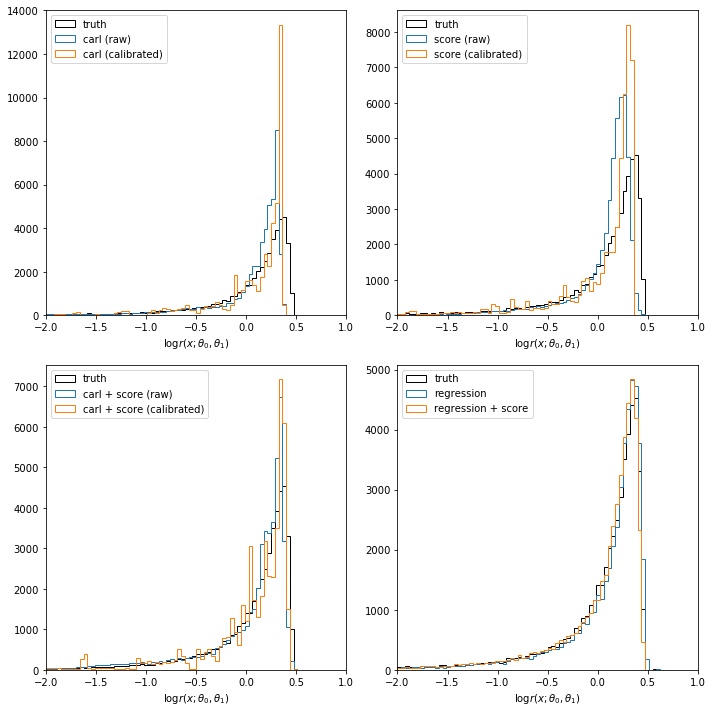

In [10]:
fig = plt.figure(figsize=(10.,10.))
this_range=(-2.,1.)
this_bins = 80



ax = plt.subplot(221)
plt.hist(np.log(r_trained_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
if do_carl:
    plt.hist(np.log(r_trained_carl), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='carl (raw)')
if do_carl2:
    plt.hist(np.log(r_trained_carl2), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='carl (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(222)
plt.hist(np.log(r_trained_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
if do_score:
    plt.hist(np.log(r_trained_score), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='score (raw)')
if do_score2:
    plt.hist(np.log(r_trained_score2), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='score (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(223)
plt.hist(np.log(r_trained_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
if do_combined:
    plt.hist(np.log(r_trained_combined), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='carl + score (raw)')
if do_combined2:
    plt.hist(np.log(r_trained_combined2), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='carl + score (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(224)
plt.hist(np.log(r_trained_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
if do_regression:
    plt.hist(np.log(r_trained_regression), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='regression')
if do_combinedregression:
    plt.hist(np.log(r_trained_combinedregression), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='regression + score')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



plt.tight_layout()
plt.savefig("figures/parameterized_r_histograms_" + main_mode + ".pdf")

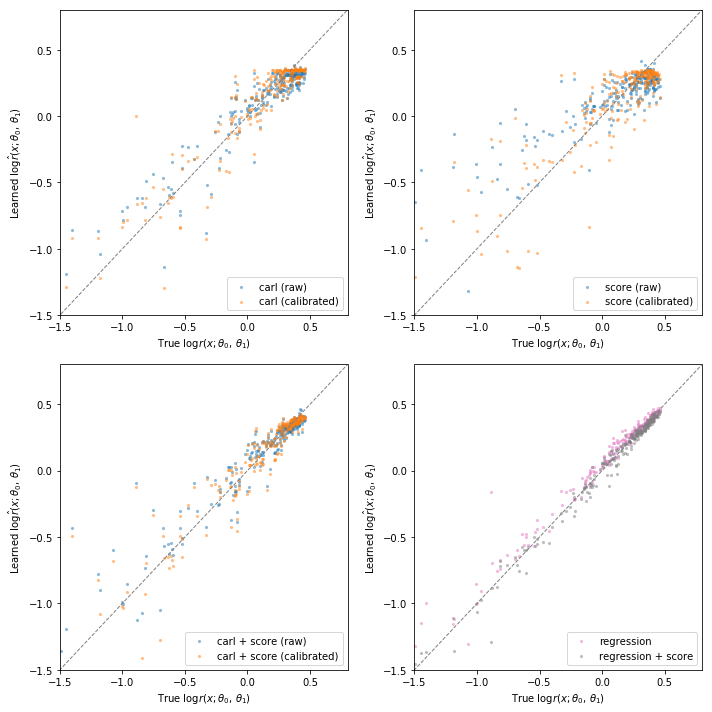

In [11]:
fig = plt.figure(figsize=(10.,10.))
xmin = -1.5
xmax = 0.8



ax = plt.subplot(221)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_carl[::200]),
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='carl (raw)')
if do_carl2:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_carl2[::200]),
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='carl (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(222)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_score[::200]),
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='score (raw)')
if do_score2:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_score2[::200]),
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='score (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(223)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_combined:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_combined[::200]),
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='carl + score (raw)')
if do_combined2:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_combined2[::200]),
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label=r'carl + score (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(224)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_regression[::200]),
                marker='o', alpha=0.5, s=10., c='C6', lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(np.log(r_trained_truth[::200]), np.log(r_trained_combinedregression[::200]),
                marker='o', alpha=0.5, s=10., c='C7', lw=0.,
                label='regression + score')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



plt.tight_layout()
plt.savefig("figures/parameterized_r_scatter_" + main_mode + ".pdf")

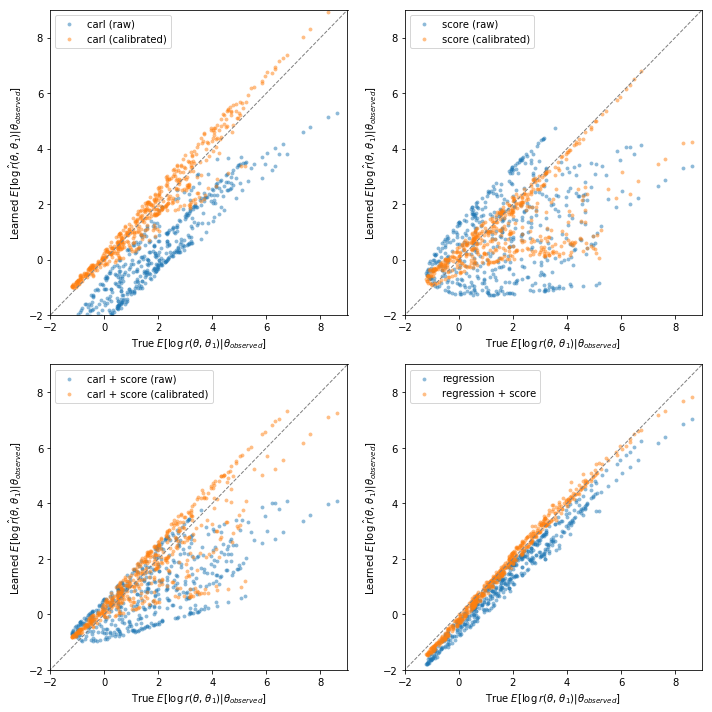

In [12]:
fig = plt.figure(figsize=(10.,10.))



ax = plt.subplot(221)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(llr_truth[::2], llr_carl[::2],
                marker='o', color='C0', alpha=0.5, s=15.,  lw=0.,
                label='carl (raw)')
if do_carl2:
    plt.scatter(llr_truth[::2], llr_carl2[::2],
                marker='o', color='C1', alpha=0.5, s=15.,  lw=0.,
                label='carl (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-2.,9.)
plt.ylim(-2.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(222)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(llr_truth[::2], llr_score[::2], 
                marker='o', color='C0', alpha=0.5, s=15., lw=0.,
                label='score (raw)')
if do_score2:
    plt.scatter(llr_truth[::2], llr_score2[::2], 
                marker='o', color='C1', alpha=0.5, s=15., lw=0.,
                label='score (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-2.,9.)
plt.ylim(-2.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(223)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_combined:
    plt.scatter(llr_truth[::2], llr_combined[::2],
                marker='o', color='C0', alpha=0.5, s=15., lw=0.,
                label='carl + score (raw)')
if do_combined2:
    plt.scatter(llr_truth[::2], llr_combined2[::2],
                marker='o', color='C1', alpha=0.5, s=15., lw=0.,
                label='carl + score (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-2.,9.)
plt.ylim(-2.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(224)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(llr_truth[::2], llr_regression[::2],
                marker='o', color='C0', alpha=0.5, s=15., lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(llr_truth[::2], llr_combinedregression[::2],
                marker='o', color='C1', alpha=0.5, s=15., lw=0.,
                label='regression + score')
plt.legend(loc='upper left')
plt.xlim(-2.,9.)
plt.ylim(-2.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")

plt.tight_layout()
plt.savefig("figures/parameterized_expected_likelihood_scatter_" + main_mode + ".pdf")

# Score scatter plots

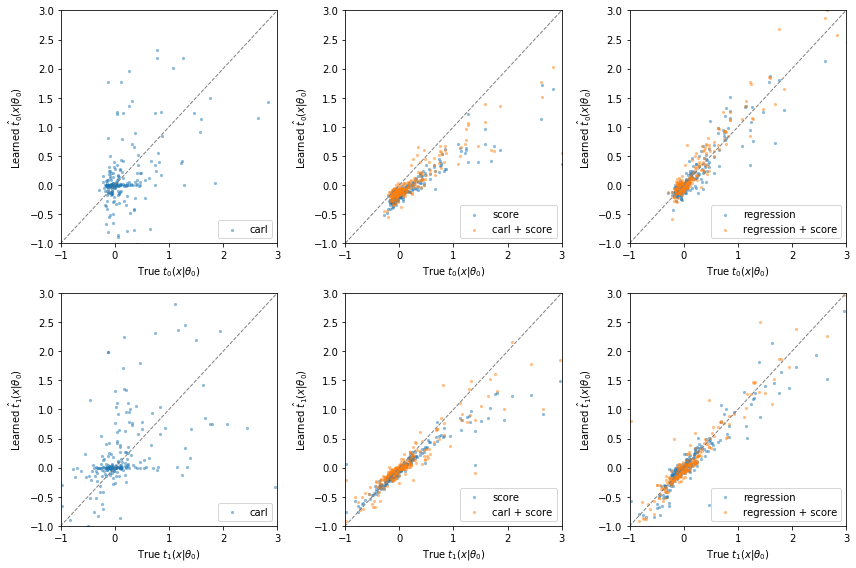

In [13]:
fig = plt.figure(figsize=(12.,8.))



ax = plt.subplot(231)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(scores_trained_truth[::200,0],scores_trained_carl[::200,0],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='carl')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(234)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(scores_trained_truth[::200,1],scores_trained_carl[::200,1],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='carl')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



ax = plt.subplot(232)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(scores_trained_truth[::200,0],scores_trained_score[::200,0],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='score')
if do_combined:
    plt.scatter(scores_trained_truth[::200,0],scores_trained_combined[::200,0],
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='carl + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(235)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(scores_trained_truth[::200,1],scores_trained_score[::200,1],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='score')
if do_combined:
    plt.scatter(scores_trained_truth[::200,1],scores_trained_combined[::200,1],
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='carl + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



ax = plt.subplot(233)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(scores_trained_truth[::200,0],scores_trained_regression[::200,0],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(scores_trained_truth[::200,0],scores_trained_combinedregression[::200,0],
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='regression + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(236)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(scores_trained_truth[::200,1],scores_trained_regression[::200,1],
                marker='o', alpha=0.5, s=10., c='C0', lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(scores_trained_truth[::200,1],scores_trained_combinedregression[::200,1],
                marker='o', alpha=0.5, s=10., c='C1', lw=0.,
                label='regression + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



plt.tight_layout()
plt.savefig("figures/parameterized_score_scatter_" + main_mode + ".pdf")

# Theta dependence

In [14]:
ratios = [r_roam_truth]
labels = ['truth']
filenames = ['truth']
if do_carl:
    ratios.append(r_roam_carl)
    labels.append('carl raw')
    filenames.append('carl')
if do_carl2:
    ratios.append(r_roam_carl2)
    labels.append('carl calibrated')
    filenames.append('carl_calibrated')
if do_combined:
    ratios.append(r_roam_combined)
    labels.append('carl + score raw')
    filenames.append('combined')
if do_combined2:
    ratios.append(r_roam_carl2)
    labels.append('carl + score calibrated')
    filenames.append('combined_calibrated')
if do_regression:
    ratios.append(r_roam_regression)
    labels.append('regression')
    filenames.append('regression')
if do_combinedregression:
    ratios.append(r_roam_combinedregression)
    labels.append('regression + score')
    filenames.append('combinedregression')

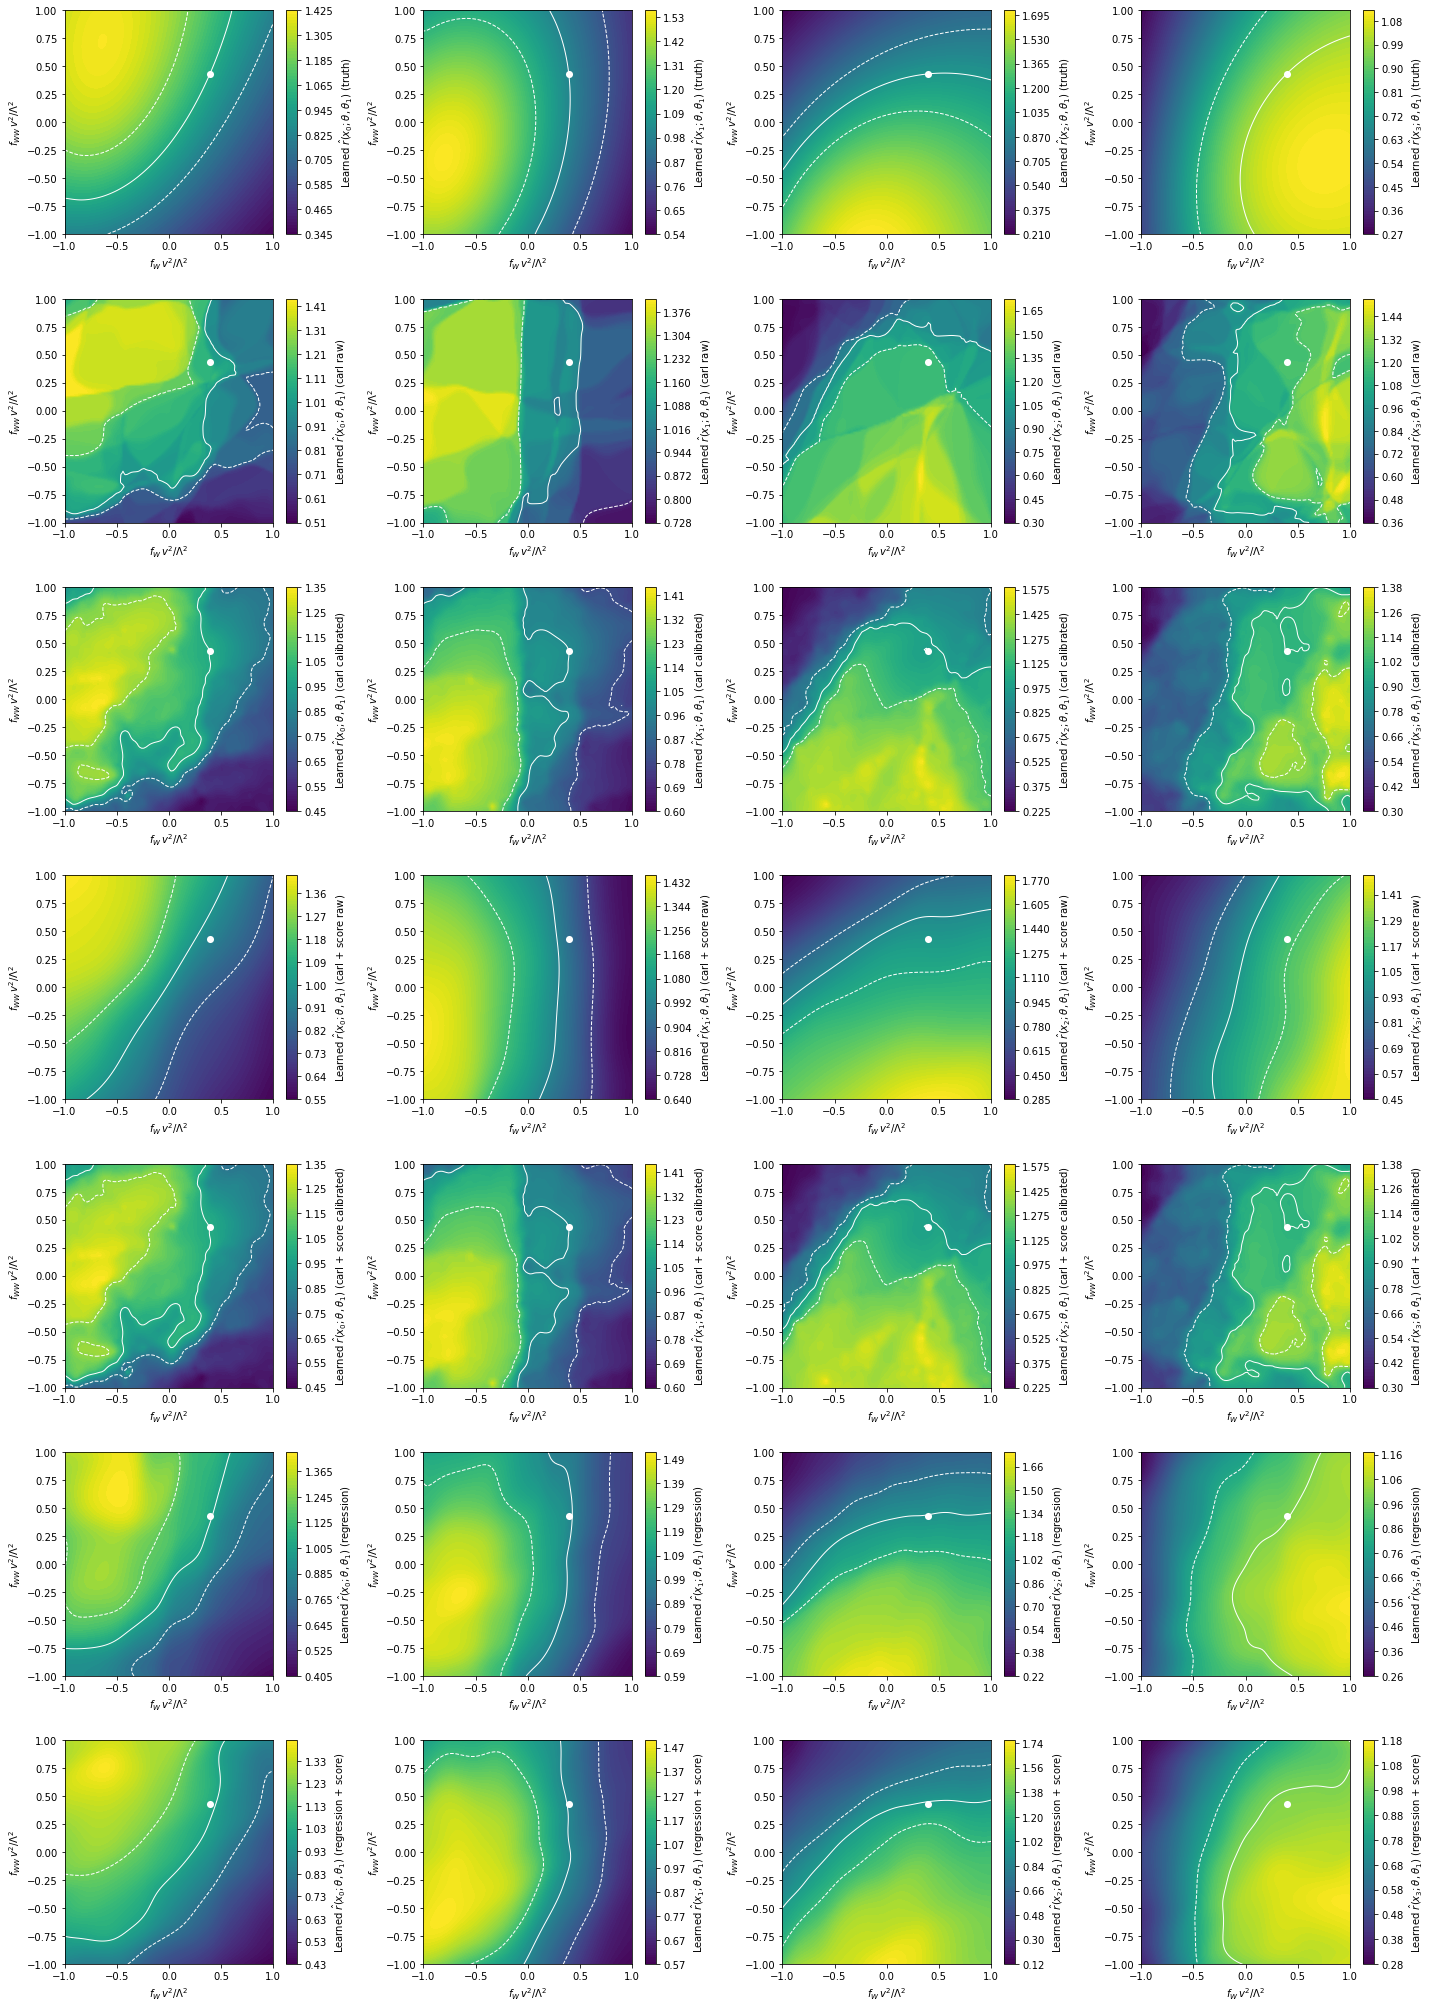

In [15]:
n_roaming = 10
show_roaming = [1,6,7,11]
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

fig = plt.figure(figsize=(5.* n_roaming_show,4. * len(ratios)))

for i, (r, l) in enumerate(zip(ratios, labels)):
    for j in range(n_roaming_show):
        ax = plt.subplot(len(ratios), n_roaming_show,1 + n_roaming_show * i + j)

        cs = plt.contourf(xi, yi, r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)), 100, cmap="viridis",
                          lw=0.)
        cbar = plt.colorbar()
        plt.contour(xi, yi, r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)), [0.8,1.,1.2],
                    linewidths=1., colors='white',
                    linestyles=['dashed','solid','dashed'])

        #plt.scatter(thetas[thetas_train,0], thetas[thetas_train,1],
        #            marker='o', c='w', alpha=0.5,  s=5., lw=0, zorder=8)
        plt.scatter([thetas[theta1, 0]], [thetas[theta1, 1]],
                    marker='o', c='w', s=50, lw=0, zorder=9)

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        cbar.set_label(r'Learned $\hat{r}(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')

plt.tight_layout()
plt.savefig("figures/parameterized_theta_dependence_comparison_" + main_mode + ".pdf")

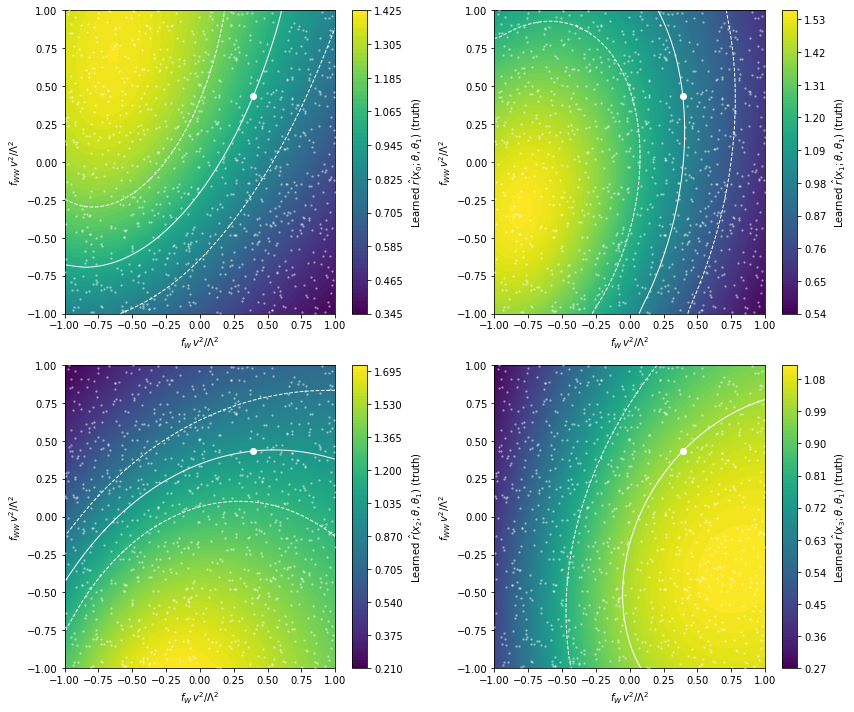

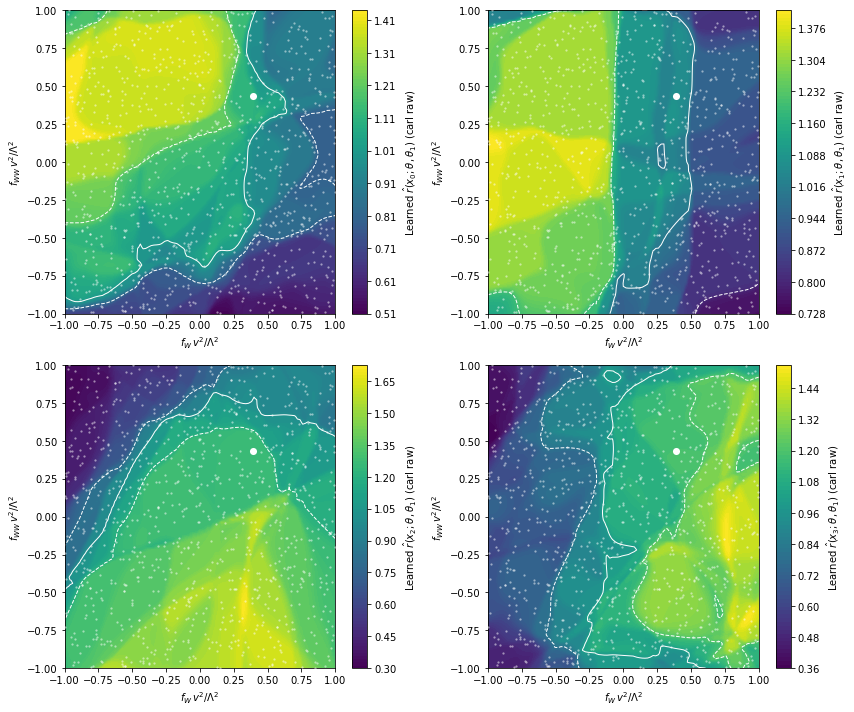

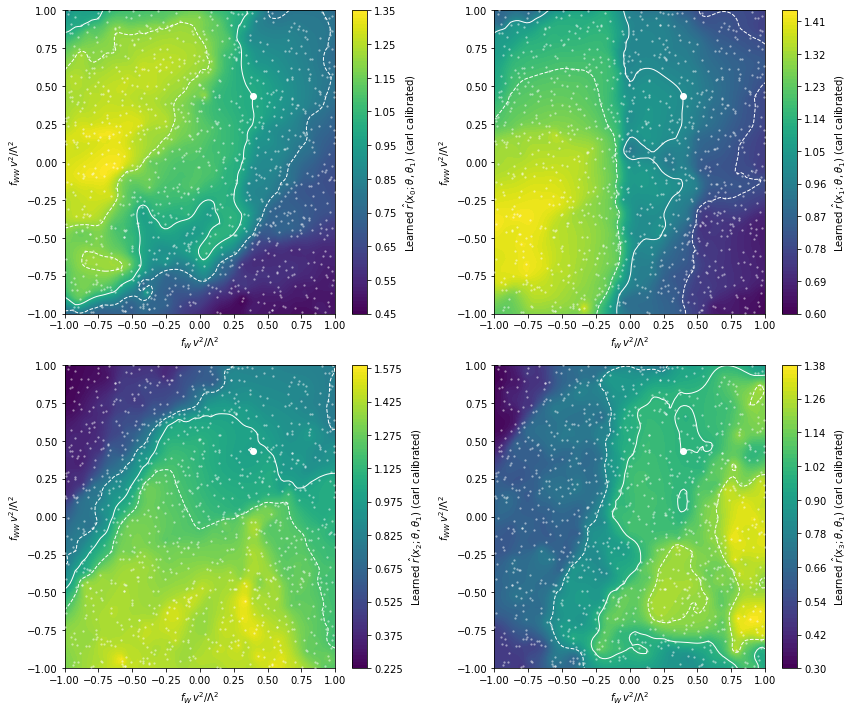

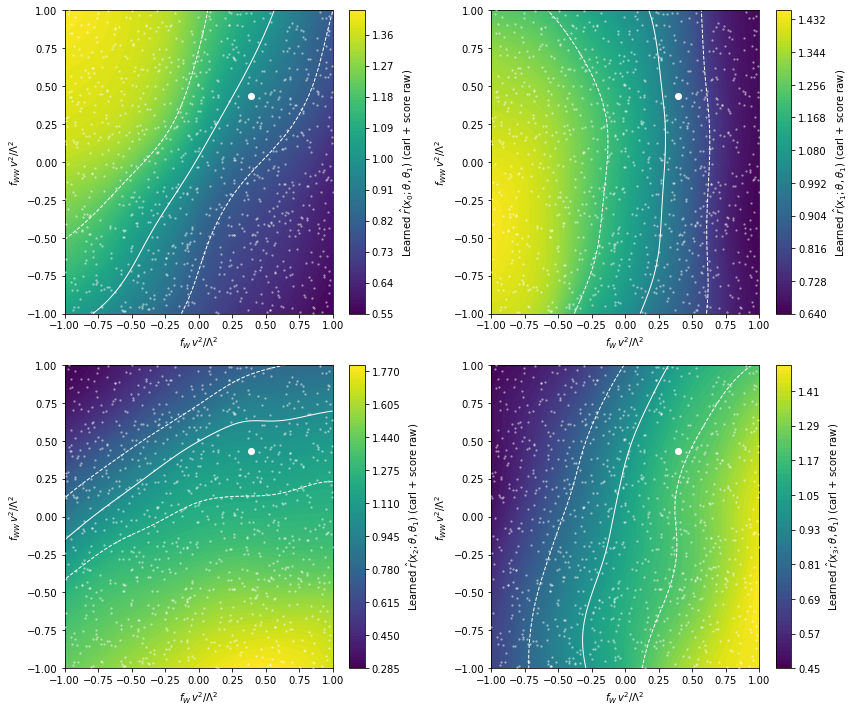

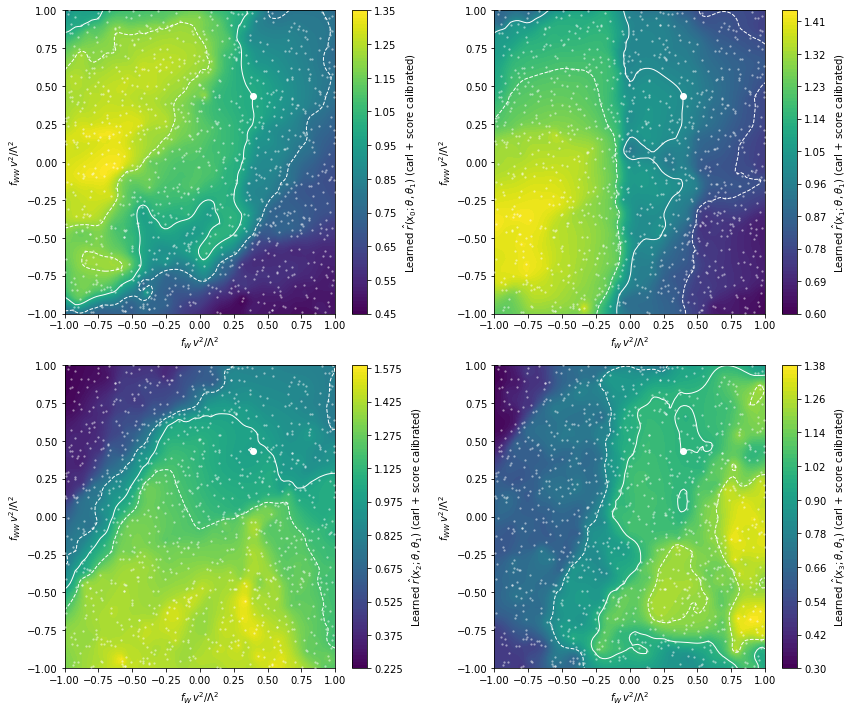

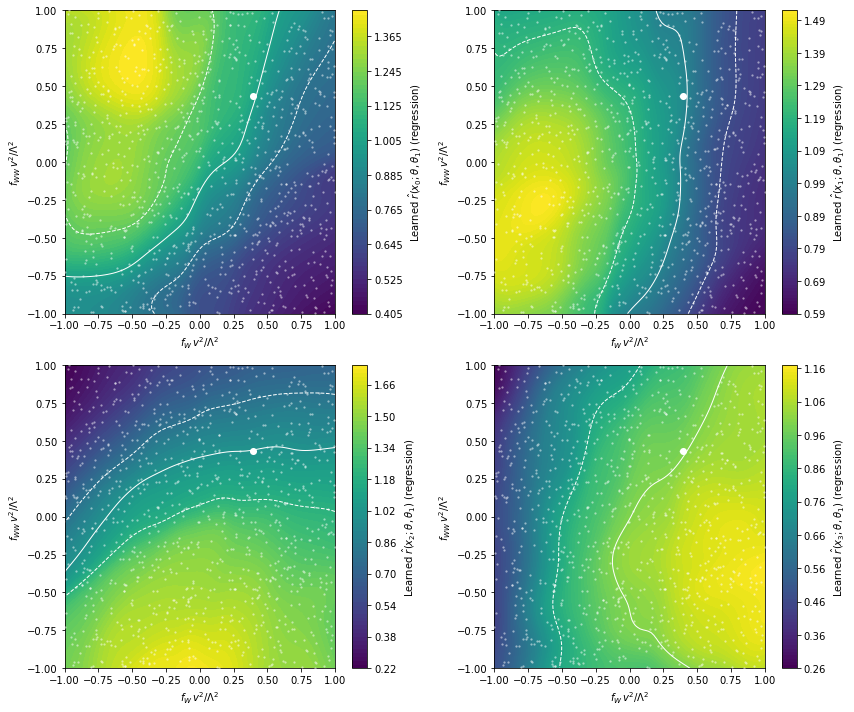

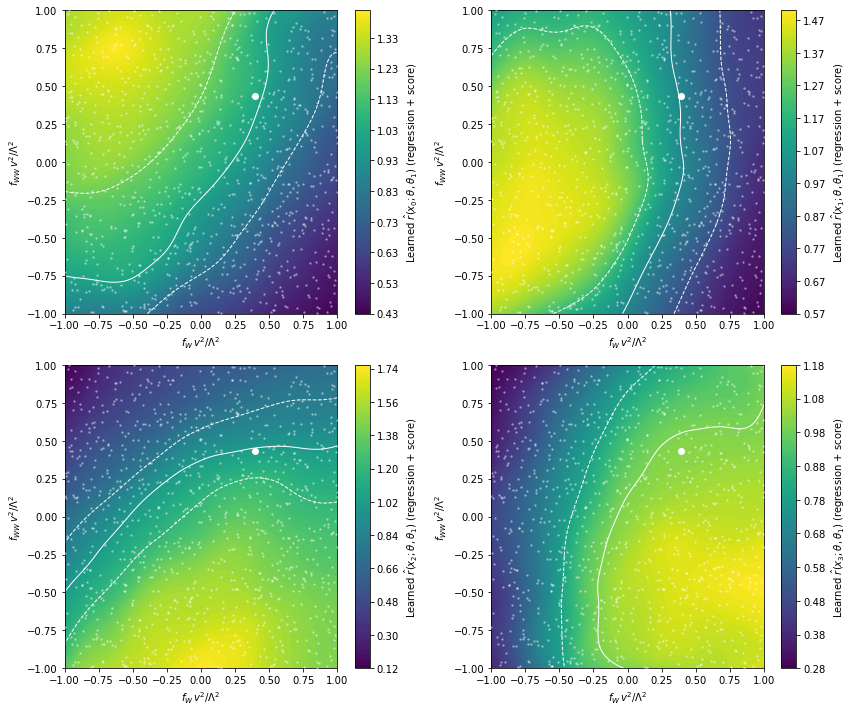

In [16]:
show_roaming = [1,6,7,11]#[9, 0, 1, 6]

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

for r, l, fn in zip(ratios, labels, filenames):
    fig = plt.figure(figsize=(12.,10.))
        
    for i in range(4):
        ax = plt.subplot(221 + i)

        cs = plt.contourf(xi, yi, r[show_roaming[i]].reshape((n_thetas_roam, n_thetas_roam)), 100, cmap="viridis",
                          lw=0.)
        cbar = plt.colorbar()
        plt.contour(xi, yi, r[show_roaming[i]].reshape((n_thetas_roam, n_thetas_roam)), [0.8,1.,1.2],
                    linewidths=1., colors='white',
                    linestyles=['dashed','solid','dashed'])

        plt.scatter(thetas[thetas_train,0], thetas[thetas_train,1],
                    marker='o', c='w', alpha=0.5,  s=5., lw=0, zorder=8)
        plt.scatter([thetas[theta1, 0]], [thetas[theta1, 1]],
                    marker='o', c='w', s=50, lw=0, zorder=9)

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        cbar.set_label(r'Learned $\hat{r}(x_' + str(i) + r'; \theta, \theta_1)$ (' + l + ')')

    plt.tight_layout()
    plt.savefig("figures/parameterized_theta_dependence_" + fn + "_" + main_mode + ".pdf")

# x dependence

In [17]:
ratios = [r_trained_truth]
labels = ['truth']
if do_carl:
    ratios.append(r_trained_carl)
    labels.append('carl raw')
if do_carl2:
    ratios.append(r_trained_carl2)
    labels.append('carl calibrated')
if do_combined:
    ratios.append(r_trained_combined)
    labels.append('carl + score raw')
if do_combined2:
    ratios.append(r_trained_carl2)
    labels.append('carl + score calibrated')
if do_regression:
    ratios.append(r_trained_regression)
    labels.append('regression')
if do_combinedregression:
    ratios.append(r_trained_combinedregression)
    labels.append('regression + score')

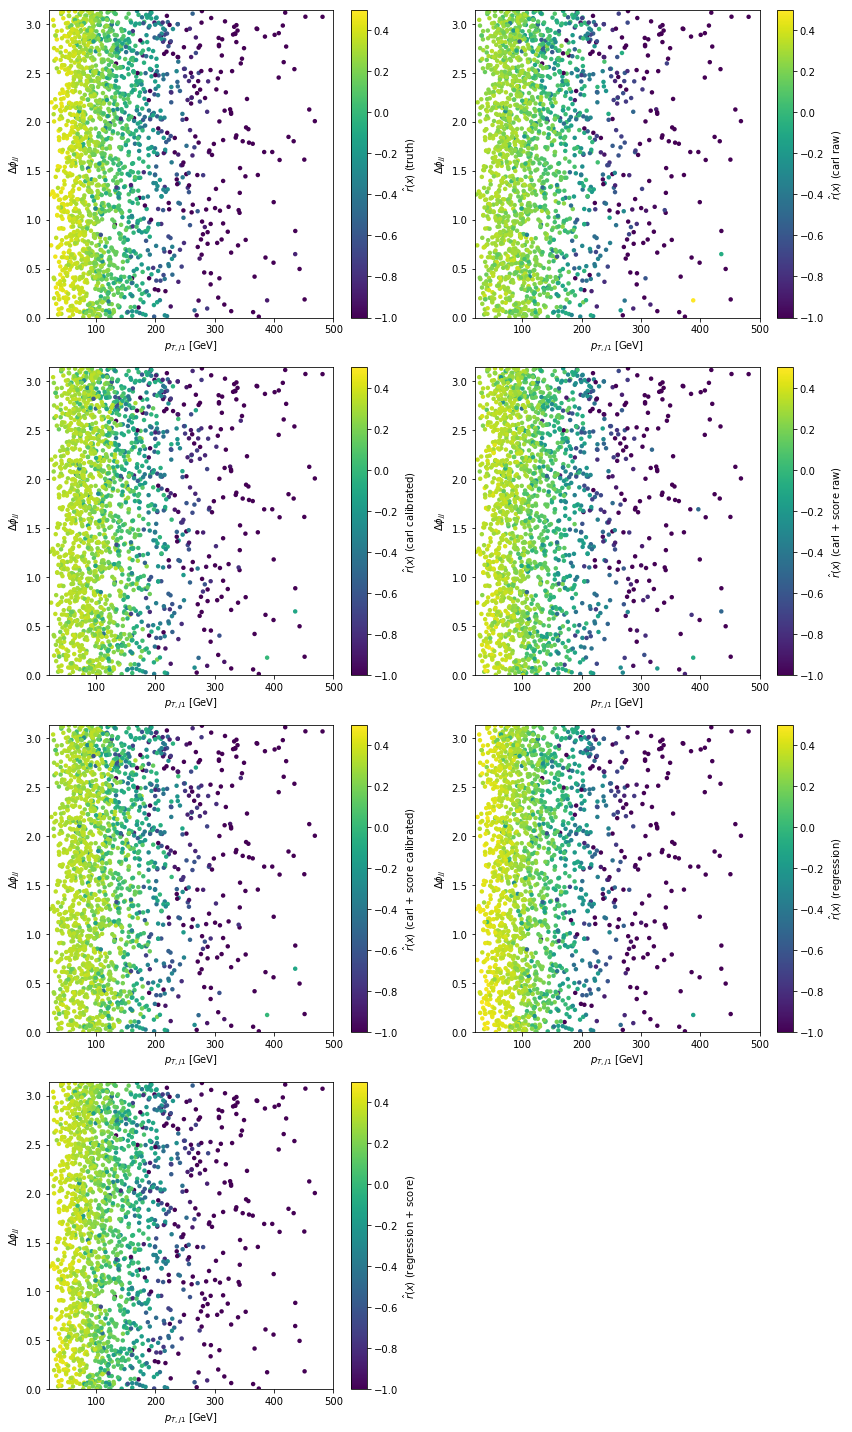

In [18]:
fig = plt.figure(figsize=(12.,20.))

for i, (d, l) in enumerate(zip(ratios, labels)):
    ax = plt.subplot(4, 2, i + 1)

    plt.scatter(X_observed[::25,1],
                X_observed[::25,41],
                c=np.log(d[::25]),
                vmin=-1., vmax=0.5,
                marker='o', s=20., lw=0.)
    cbar = plt.colorbar()
    
    plt.xlim(20.,500.)
    plt.ylim(0.,math.pi)
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    cbar.set_label(r'$\hat{r}(x)$ (' + l + ')')

plt.tight_layout()
plt.savefig('figures/parameterized_x_dependence_' + main_mode + '.pdf')

# Likelihood over theta

In [19]:
def interpolate(thetas, z_thetas,
                xx, yy,
                xi=None, yi=None,
                use_gp=False):
    
    if use_gp:
        gp = GaussianProcessRegressor(normalize_y=True, 
                                      kernel=C(1.0) * Matern(1.0,nu=0.5), n_restarts_optimizer=10)
        gp.fit(thetas[:], z_thetas[:])
        zz, _ = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
        zi = zz.reshape(xx.shape)
    else:
        zi = griddata(thetas[:, 0], thetas[:, 1], z_thetas, xi, yi, interp='linear')
        
    mle = np.unravel_index(zi.argmin(),zi.shape)
    #zi -= zi[mle]
    zi *= 2.
    return zi, mle


def interpolate_with_uncertainties(thetas,
                                   z_thetas, delta_z_thetas,
                                   xx, yy, 
                                   xi=None, yi=None,
                                   use_gp=interpolate_gp):
    zi, mle = interpolate(thetas, z_thetas, xx, yy, xi, yi, use_gp)
    zi_diff = zi - zi[mle]
    zi_upper, _ = interpolate(thetas, z_thetas + delta_z_thetas, xx, yy, xi, yi, use_gp)
    zi_upper -= zi[mle]
    zi_lower, _ = interpolate(thetas, z_thetas - delta_z_thetas, xx, yy, xi, yi, use_gp)
    zi_lower -= zi[mle]
    return zi_diff, mle, zi_upper, zi_lower


# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 500)
yi = np.linspace(-1.0, 1.0, 500)
xx, yy = np.meshgrid(xi, yi)

# interpolate
zi_truth, mle_truth, zi_truth_upper, zi_truth_lower = interpolate_with_uncertainties(
                                                    thetas, llr_truth, llr_uncertainties_truth,
                                                        xx, yy, xi, yi)
if do_carl:
    zi_carl, mle_carl, zi_carl_upper, zi_carl_lower = interpolate_with_uncertainties(thetas, llr_carl,
                                                                  llr_uncertainties_carl,
                                                                    xx, yy, xi, yi)
if do_carl2:
    zi_carl2, mle_carl2, zi_carl2_upper, zi_carl2_lower = interpolate_with_uncertainties(thetas, llr_carl2,
                                                                  llr_uncertainties_carl2,
                                                                    xx, yy, xi, yi)
if do_score:
    zi_score, mle_score, zi_score_upper, zi_score_lower = interpolate_with_uncertainties(thetas, llr_score,
                                                                  llr_uncertainties_score,
                                                                    xx, yy, xi, yi)
if do_score2:
    zi_score2, mle_score2, zi_score2_upper, zi_score2_lower = interpolate_with_uncertainties(thetas, llr_score2,
                                                                  llr_uncertainties_score2,
                                                                    xx, yy, xi, yi)
if do_combined:
    zi_combined, mle_combined, zi_combined_upper, zi_combined_lower = interpolate_with_uncertainties(
                                                    thetas, llr_combined, llr_uncertainties_combined,
                                                     xx, yy, xi, yi)
if do_combined2:
    zi_combined2, mle_combined2, zi_combined2_upper, zi_combined2_lower = interpolate_with_uncertainties(
                                                    thetas, llr_combined2, llr_uncertainties_combined2,
                                                     xx, yy, xi, yi)
if do_regression:
    zi_regression, mle_regression, zi_regression_upper, zi_regression_lower = interpolate_with_uncertainties(
                                                                   thetas, llr_regression,
                                                                  llr_uncertainties_regression,
                                                                    xx, yy, xi, yi)
if do_combinedregression:
    zi_combinedregression, mle_combinedregression, zi_combinedregression_upper, \
    zi_combinedregression_lower = interpolate_with_uncertainties(thetas, llr_combinedregression,
                                                         llr_uncertainties_combinedregression,
                                                         xx, yy, xi, yi)

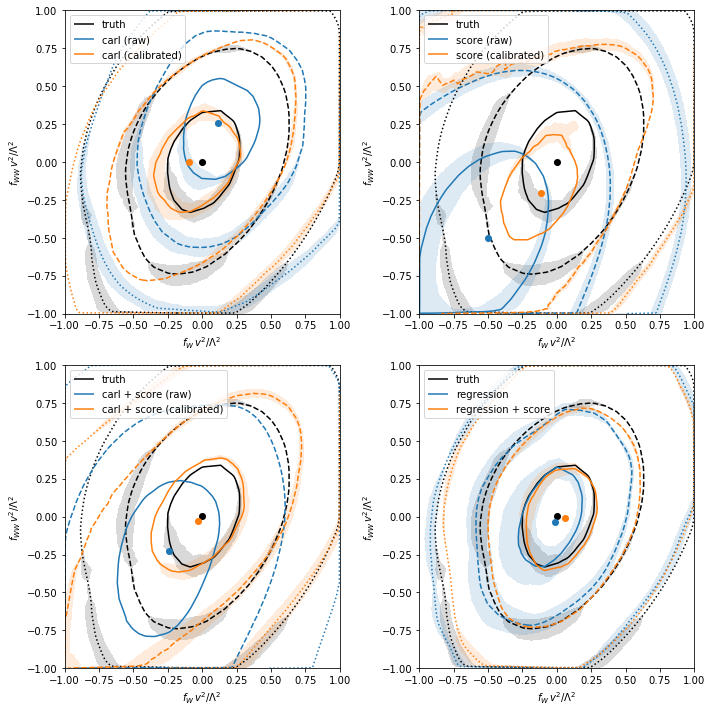

In [20]:
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in [1.,4.,9.]:
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5], colors=color, alpha=0.15)
        
        

xi = np.linspace(-1.0, 1.0, 500)
yi = np.linspace(-1.0, 1.0, 500)
xx, yy = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(10.,10.))



plt.subplot(221)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_carl:
    plot_errorbands(xi, yi, zi_carl_upper, zi_carl_lower, 'C0')
if do_carl2:
    plot_errorbands(xi, yi, zi_carl2_upper, zi_carl2_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_carl:
    cs = plt.contour(xi, yi, zi_carl, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('carl (raw)')
if do_carl2:
    cs = plt.contour(xi, yi, zi_carl2, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('carl (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_carl:
    plt.scatter([xi[mle_carl[1]]], [yi[mle_carl[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_carl2:
    plt.scatter([xi[mle_carl2[1]]], [yi[mle_carl2[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$-2 \, E[\Delta \, \log \, {L}]$ (truth)')



plt.subplot(222)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_score:
    plot_errorbands(xi, yi, zi_score_upper, zi_score_lower, 'C0')
if do_score2:
    plot_errorbands(xi, yi, zi_score2_upper, zi_score2_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_score:
    cs = plt.contour(xi, yi, zi_score, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('score (raw)')
if do_score2:
    cs = plt.contour(xi, yi, zi_score2, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('score (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_score:
    plt.scatter([xi[mle_score[1]]], [yi[mle_score[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_score2:
    plt.scatter([xi[mle_score2[1]]], [yi[mle_score2[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$-2 \, E[\Delta \, \log \, {L}]$ (truth)')



plt.subplot(223)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_combined:
    plot_errorbands(xi, yi, zi_combined_upper, zi_combined_lower, 'C0')
if do_combined2:
    plot_errorbands(xi, yi, zi_combined2_upper, zi_combined2_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_combined:
    cs = plt.contour(xi, yi, zi_combined, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('carl + score (raw)')
if do_combined2:
    cs = plt.contour(xi, yi, zi_combined2, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('carl + score (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_combined:
    plt.scatter([xi[mle_combined[1]]], [yi[mle_combined[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_combined2:
    plt.scatter([xi[mle_combined2[1]]], [yi[mle_combined2[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$-2 \, E[\Delta \, \log \, {L}]$ (truth)')



plt.subplot(224)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_regression:
    plot_errorbands(xi, yi, zi_regression_upper, zi_regression_lower, 'C0')
if do_combinedregression:
    plot_errorbands(xi, yi, zi_combinedregression_upper, zi_combinedregression_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black', 
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_regression:
    cs = plt.contour(xi, yi, zi_regression, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('regression')
if do_combinedregression:
    cs = plt.contour(xi, yi, zi_combinedregression, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('regression + score')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_regression:
    plt.scatter([xi[mle_regression[1]]], [yi[mle_regression[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_combinedregression:
    plt.scatter([xi[mle_combinedregression[1]]], [yi[mle_combinedregression[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$-2 \, E[\Delta \, \log \, {L}]$ (truth)')



plt.tight_layout()
plt.savefig("figures/parameterized_likelihood_contours_" + main_mode + ".pdf")